# Analyzing Crime in Vancouver
By: Ryan Saloff 32061624, Yash Mirani 78159415, Aditya Bakshi 28483832, Eva Ma 36961662

In [1]:
# Loads the packages used in the data analysis
library(IRdisplay)
library(cowplot)
library(digest)
library(gridExtra)
library(infer)
library(repr)
library(tidyverse)
library(datateachr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine()   masks gridExtra::combine()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ lubridate::stamp() masks cowplot::stamp()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Introduction

The data set we are using is extracted from the PRIME BC Police Records Management System (RMS), regarding the instances of crime within Vancouver from 2003-2023. The columns describe the distinct types of crime, relating to the date/time, along with the specificities of the location in which the crime has occurred. This has enticed us to question: has the rate of theft and break/enter in Vancouver increased over the years? There is a positive correlation between crime and unemployment rates, as an increase in unemployment implicates an increase in acts of violence (Phillip et al., 2012). According to the graph attached below (StatCan, 2023), the average unemployment rate from 2004-2008 is 5.34%, while the rate from 2018-2022 is 6.2%. Phillip et al. (2012) state how we would expect that the crime rates to be higher given the unemployment rates throughout the years. On the other hand, Anderson et al., (2017) explain how crime rates in Vancouver should have reduced over time. Having two opposing implications, we investigate the crime rates of Vancouver to see which approach is supported by the given data. Crimes of theft, and break/enter are two indicators of crime that we will be focussing on, as they would correlate with unemployment, and thus be able to support our testing to answer our question regarding the crimes in Vancouver. 

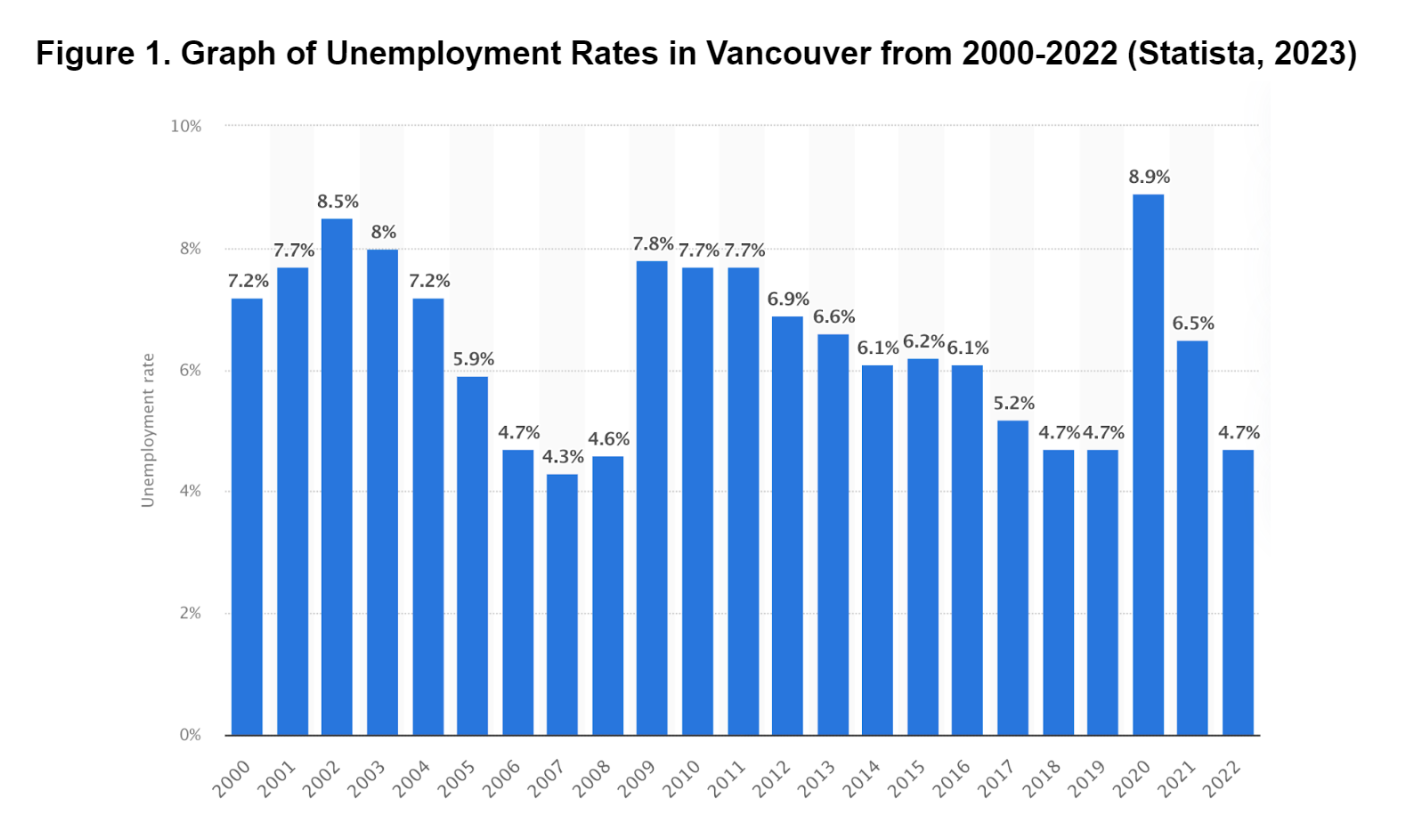

In [2]:
display_png(file = "Unemployment.png")

## Preliminary Results

#### Read Data from the Web

In [3]:
# Loads the dataset from the web
dataset <- read.csv(url("https://docs.google.com/spreadsheets/d/1SXkE_T-CmZzd1kPAIArQOLg9GQa_ftnmVMAI30sVDqo/export?gid=277724310&format=csv")) 

# Prints the first 6 rows of the dataset
table_1 <- "Table 1 - First Six Columns of the Dataset"
table_1
head(dataset)

# Prints the last 6 rows of the dataset
table_2 <- "Table 2 - Last Six Columns of the Dataset"
table_2
tail(dataset)

[1] "Table 1 - First Six Columns of the Dataset"

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,Break and Enter Commercial,2012,12,14,8,52,,Oakridge,491285.0,5453433
2,Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490613.0,5457110
3,Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.8,5459174
4,Break and Enter Commercial,2021,4,26,4,44,10XX ALBERNI ST,West End,491007.8,5459174
5,Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.9,5459166
6,Break and Enter Commercial,2020,7,28,19,12,10XX ALBERNI ST,West End,491015.9,5459166


[1] "Table 2 - Last Six Columns of the Dataset"

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
877874,Vehicle Collision or Pedestrian Struck (with Injury),2023,2,22,12,12,YUKON ST / W BROADWAY AVE,Mount Pleasant,491786,5456719
877875,Vehicle Collision or Pedestrian Struck (with Injury),2003,9,1,20,45,YUKON ST / W KING EDWARD AVE,Riley Park,491786,5455143
877876,Vehicle Collision or Pedestrian Struck (with Injury),2005,7,20,18,57,YUKON ST / W KING EDWARD AVE,Riley Park,491786,5455143
877877,Vehicle Collision or Pedestrian Struck (with Injury),2016,6,20,18,11,YUKON ST / W KING EDWARD AVE,Riley Park,491786,5455143
877878,Vehicle Collision or Pedestrian Struck (with Injury),2013,12,3,9,49,YUKON ST / W KING EDWARD AVE,Riley Park,491835,5455126
877879,Vehicle Collision or Pedestrian Struck (with Injury),2013,12,27,14,40,YUKON ST / W KING EDWARD AVE,Riley Park,491835,5455126


#### Cleaning and Wrangling

In [4]:
# Removes the X and Y columns as well as inaccurate data
tidy_dataset <- dataset |>
    select(TYPE, YEAR) |>
    na.omit()

# Prints the first 6 rows of the dataset
table_3 <- "Table 3 - First Six Columns of the Tidy Dataset"
table_3
head(tidy_dataset)

# Prints the last 6 rows of the dataset
table_4 <- "Table 4 - Last Six Columns of the Tidy Dataset"
table_4
tail(tidy_dataset)

[1] "Table 3 - First Six Columns of the Tidy Dataset"

,TYPE,YEAR
,<chr>,<int>
1,Break and Enter Commercial,2012
2,Break and Enter Commercial,2019
3,Break and Enter Commercial,2019
4,Break and Enter Commercial,2021
5,Break and Enter Commercial,2014
6,Break and Enter Commercial,2020


[1] "Table 4 - Last Six Columns of the Tidy Dataset"

,TYPE,YEAR
,<chr>,<int>
877874,Vehicle Collision or Pedestrian Struck (with Injury),2023
877875,Vehicle Collision or Pedestrian Struck (with Injury),2003
877876,Vehicle Collision or Pedestrian Struck (with Injury),2005
877877,Vehicle Collision or Pedestrian Struck (with Injury),2016
877878,Vehicle Collision or Pedestrian Struck (with Injury),2013
877879,Vehicle Collision or Pedestrian Struck (with Injury),2013


#### Plotting the Raw Data

We will start by plotting the population data to visualize the number of other thefts and break and enters, out of the total number of crimes between 2004-2008 and 2018-2022.

In [5]:
# Filters the dataset for crimes during 2004 - 2008 and 2018 - 2022

raw_data <- tidy_dataset |>
    filter(YEAR %in% (2004:2008) | YEAR %in% (2018:2022)) |>
    group_by(TYPE, YEAR) |>
    summarize(n = n()) |>
    mutate(ranges = cut(YEAR, c(2004, 2008, 2017, 2022),
                        labels = c("[2004, 2008]","NA", "[2018, 2022]"), include.lowest = TRUE)) 

`summarise()` has grouped output by 'TYPE'. You can override using the
`.groups` argument.


In [6]:
# Calculates the sum of each crime

pop_1 = raw_data |>
    filter(ranges == "[2004, 2008]") |>
    summarize(n = sum(n))

# Number of crimes from 2004 - 2008
pop_1_total_crime = pop_1 |>
    summarize(n = sum(n)) |>
    as.numeric()

# Number of other thefts from 2004 - 2008
pop_1_other_thefts = pop_1 |>
    filter(TYPE == "Other Theft") |>
    summarize(n = sum(n)) |>
    as.numeric()

# Number of break and enters from 2004 - 2008
pop_1_bne = pop_1 |>
    filter(TYPE == "Break and Enter Commercial" | TYPE == "Break and Enter Residential/Other") |>
    summarize(n = sum(n)) |>
    as.numeric()

pop_2 = raw_data |>
    filter(ranges == "[2018, 2022]") |>
    summarize(n = sum(n))

# Number of crimes from 2018 - 2022
pop_2_total_crime = pop_2 |>
    summarize(n = sum(n)) |>
    as.numeric()

# Number of other thefts from 2018 - 2022
pop_2_other_thefts = pop_2 |>
    filter(TYPE == "Other Theft") |>
    summarize(n = sum(n)) |>
    as.numeric()

# Number of break and enters from 2018 - 2022
pop_2_bne = pop_2 |>
    filter(TYPE == "Break and Enter Commercial" | TYPE == "Break and Enter Residential/Other") |>
    summarize(n = sum(n)) |>
    as.numeric()

crimes <- c(pop_1_bne, pop_1_other_thefts, pop_1_total_crime, pop_2_bne, pop_2_other_thefts, pop_2_total_crime)

labels <- c("Break and Enters", "Other Thefts", "All Crimes","Break and Enters", "Other Thefts", "All Crimes")

years <- c("2004-2008","2004-2008","2004-2008","2018-2022","2018-2022","2018-2022")

# Creates the table of the number of crimes in each year
crimes_table <- tibble(labels, years, crimes)

comment(table) <- "Table 5 - Types of Crimes in Year Range"

comment(table)
crimes_table

[1] "Table 5 - Types of Crimes in Year Range"

labels,years,crimes
<chr>,<chr>,<dbl>
Break and Enters,2004-2008,40591
Other Thefts,2004-2008,52281
All Crimes,2004-2008,247250
Break and Enters,2018-2022,20861
Other Thefts,2018-2022,51555
All Crimes,2018-2022,196376


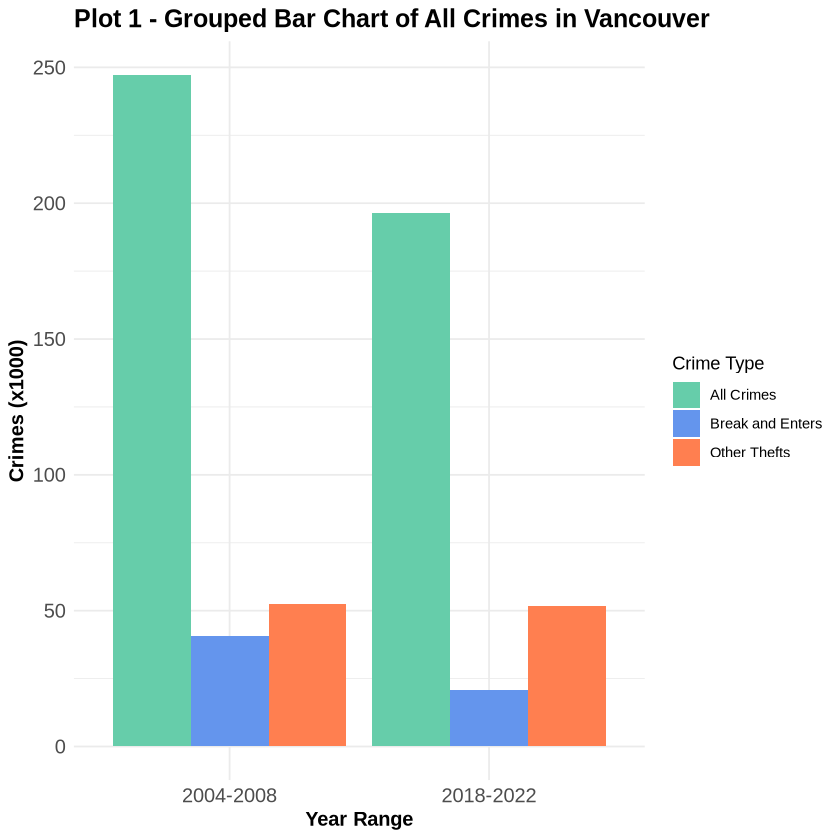

In [7]:
# Plots the number of crimes in each year
raw_data_plot <- crimes_table |>
    ggplot(aes(x = years, y = crimes/1000, fill = labels)) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(title = "Plot 1 - Grouped Bar Chart of All Crimes in Vancouver",
    x = "Year Range",
    y = "Crimes (x1000)",
        fill = "Crime Type") +
    scale_fill_manual(values = c("All Crimes" = "aquamarine3", "Break and Enters" = "cornflower blue", "Other Thefts" = "coral")) +
    theme_minimal() +
    theme(axis.text=element_text(size=12),
        axis.title=element_text(size=12,face="bold"),
         plot.title = element_text(size = 15, face = "bold"))

raw_data_plot

Now, we will calculate the population parameters (difference of proportion of each type of crime out of all crimes) for the 2004-2008 and 2018-2022 year ranges. The population parameter will be used to evaluate the accuracy of our data analysis.

In [8]:
# Calculates and and creates the proportion difference vector
prop_diff <- c(crimes_table$crimes[4]/crimes_table$crimes[6] - crimes_table$crimes[1]/crimes_table$crimes[3],
          crimes_table$crimes[5]/crimes_table$crimes[6] - crimes_table$crimes[2]/crimes_table$crimes[3])

# Creates the crime type vector
crime <- c("Break and Enters","Other Thefts")

# Creates the table with each vector
pop_prop <- tibble(crime, prop_diff)

comment(pop_prop) <- "Table 6 - Difference of Proportion Parameter (2018-2022 Proportion minus 2004-2008 Proportion)"
comment(pop_prop)
pop_prop

[1] "Table 6 - Difference of Proportion Parameter (2018-2022 Proportion minus 2004-2008 Proportion)"

crime,prop_diff
<chr>,<dbl>
Break and Enters,-0.05793998
Other Thefts,0.05108213


#### Estimating the Parameter ####

In [9]:
# Filters the dataset for years 2004 - 2008 and selects the type of crime and the neighbourhood
crime_2004_2008 <- tidy_dataset |>
    filter(YEAR %in% (2004:2008)) |>
    select(TYPE)

# Prints the first 6 rows of the dataset
table_7 <- "Table 7 - All Crimes from 2004 - 2008"
table_7
head(crime_2004_2008)

[1] "Table 7 - All Crimes from 2004 - 2008"

,TYPE
,<chr>
1,Break and Enter Commercial
2,Break and Enter Commercial
3,Break and Enter Commercial
4,Break and Enter Commercial
5,Break and Enter Commercial
6,Break and Enter Commercial


In [10]:
set.seed(1)

# Randomly samples the 2004-2008 crime population (size = 500)
sample_2004_2008 <- crime_2004_2008 |>
    rep_sample_n(size = 500, replace = FALSE) |>
    ungroup() |>
    select(-replicate)

# Filters for "Other Theft" from the random sample
other_theft_2004_2008 <- sample_2004_2008 |>
    filter(TYPE == "Other Theft") 

# Calculates p̂ for other theft from 2004-2008
phat_theft_1 <- nrow(other_theft_2004_2008)/nrow(sample_2004_2008)

# Prints the other theft proportion estimate from 2004-2008
print(paste0("The estimated proportion of other theft crimes out of all crimes in Vancouver from 2004 - 2008 is ", phat_theft_1, "."))

# Filters for "Break and Enter Commercial" and "Break and Enter Residential/Other" from the random sample
break_and_enter_2004_2008 <- sample_2004_2008 |>
    filter(TYPE == "Break and Enter Commercial" | TYPE == "Break and Enter Residential/Other") 

# Calculates p̂ for break and enters from 2004-2008
phat_bne_1 <- nrow(break_and_enter_2004_2008)/nrow(sample_2004_2008)

# Prints the break and enter proportion estimate from 2004-2008
print(paste0("The estimated proportion of break and enter crimes out of all crimes in Vancouver from 2004 - 2008 is ", phat_bne_1, "."))

[1] "The estimated proportion of other theft crimes out of all crimes in Vancouver from 2004 - 2008 is 0.21."
[1] "The estimated proportion of break and enter crimes out of all crimes in Vancouver from 2004 - 2008 is 0.196."


Now, we will find the sample proportions for the crimes of interest, between 2018 and 2022.

In [11]:
# Filters the dataset for years 2004 - 2008 and selects the type of crime and the neighbourhood
crime_2018_2022 <- tidy_dataset |>
    filter(YEAR %in% (2018:2022)) |>
    select(TYPE)

# Prints the first 6 rows of the dataset
table_8 <- "Table 8 - All Crimes from 2018 - 2022"
table_8
head(crime_2018_2022)

[1] "Table 8 - All Crimes from 2018 - 2022"

,TYPE
,<chr>
1,Break and Enter Commercial
2,Break and Enter Commercial
3,Break and Enter Commercial
4,Break and Enter Commercial
5,Break and Enter Commercial
6,Break and Enter Commercial


In [12]:
set.seed(2)

# Randomly samples the 2018-2022 crime population (size = 500)
sample_2018_2022 <- crime_2018_2022 |>
    rep_sample_n(size = 500, replace = FALSE) |>
    ungroup() |>
    select(-replicate)

# Filters for "Other Theft" from the random sample
other_theft_2018_2022 <- sample_2018_2022 |>
    filter(TYPE == "Other Theft") 

# Calculates p̂ for other theft from 2018-2022
phat_theft_2 <- nrow(other_theft_2018_2022)/nrow(sample_2018_2022)

# Prints the other theft proportion estimate from 2018-2022
print(paste0("The estimated proportion of other theft crimes out of all crimes in Vancouver from 2018 - 2022 is ", phat_theft_2, "."))

# Filters for "Break and Enter Commercial" and "Break and Enter Residential/Other" from the random sample
break_and_enter_2018_2022 <- sample_2018_2022 |>
    filter(TYPE == "Break and Enter Commercial" | TYPE == "Break and Enter Residential/Other") 

# Calculates p̂ for break and enters from 2018-2022
phat_bne_2 <- nrow(break_and_enter_2018_2022)/nrow(sample_2018_2022)

# Prints the break and enter proportion estimate from 2018-2022
print(paste0("The estimated proportion of break and enter crimes out of all crimes in Vancouver from 2018 - 2022 is ", phat_bne_2, "."))

[1] "The estimated proportion of other theft crimes out of all crimes in Vancouver from 2018 - 2022 is 0.264."
[1] "The estimated proportion of break and enter crimes out of all crimes in Vancouver from 2018 - 2022 is 0.148."


Finally, we will calculate the difference in sample proportions—our sample statistic of interest.

In [13]:
# Calculates the difference in sample proportions for other theft
phat_theft = phat_theft_2 - phat_theft_1
print(paste0("The estimated difference in proportion of other theft crimes from 2018 - 2022 and 2004 - 2008 out of all crimes in Vancouver is ", phat_theft, "."))


# Calculates the difference in sample proportions for break and enters
phat_bne = phat_bne_2 - phat_bne_1
print(paste0("The estimated difference in proportion of break and enters from 2018 - 2022 and 2004 - 2008 out of all crimes in Vancouver is ", phat_bne, "."))

[1] "The estimated difference in proportion of other theft crimes from 2018 - 2022 and 2004 - 2008 out of all crimes in Vancouver is 0.054."
[1] "The estimated difference in proportion of break and enters from 2018 - 2022 and 2004 - 2008 out of all crimes in Vancouver is -0.048."


Now, we will visualize our statistic of interest in a table.

In [14]:
# Creates the vectors in the tbale
crime <- c("Other Theft", "Break and Enters")
p_hat <- c(phat_theft, phat_bne) 

# Creates the table
p_hat_table <- tibble(crime, p_hat)

comment(p_hat_table) <- "Table 9 - Difference in Estimated Proportion of Crimes from 2018 - 2022 and 2004 - 2008"

comment(p_hat_table)
p_hat_table 

[1] "Table 9 - Difference in Estimated Proportion of Crimes from 2018 - 2022 and 2004 - 2008"

crime,p_hat
<chr>,<dbl>
Other Theft,0.054
Break and Enters,-0.048


## Results

#### Hypothesis Testing

###### Thefts Hypothesis Testing

In [15]:
# Prints a table that displays how many crimes in the sample were thefts

year <- data.frame(year_range = rep("2004-2008", times = 500))
theft <-ifelse(sample_2004_2008$TYPE == "Other Theft", "yes", "no")  
table_2004_2008 <- cbind(year, theft)

year <- data.frame(year_range = rep("2018-2022", times = 500))
theft <-ifelse(sample_2018_2022$TYPE == "Other Theft", "yes", "no")
table_2018_2022 <- cbind(year, theft)

thefts_table <- rbind(table_2004_2008, table_2018_2022) 

table_10 <- "Table 10 - Thefts in Both Samples (yes = theft)"

# Print the transformed table
table_10
head(thefts_table)

[1] "Table 10 - Thefts in Both Samples (yes = theft)"

,year_range,theft
,<chr>,<chr>
1,2004-2008,no
2,2004-2008,no
3,2004-2008,yes
4,2004-2008,no
5,2004-2008,no
6,2004-2008,no


In [16]:
thefts_null_distribution <- thefts_table |>
    specify(formula = theft ~ year_range, success = "yes") |>
    hypothesize(null = "independence") |>
    generate(reps = 1000, type = "permute") |>
    calculate(stat = "diff in props", order = c("2018-2022","2004-2008"))

head(thefts_null_distribution)

replicate,stat
<int>,<dbl>
1,-0.014
2,0.026
3,-0.042
4,0.030
5,0.014
6,-0.014


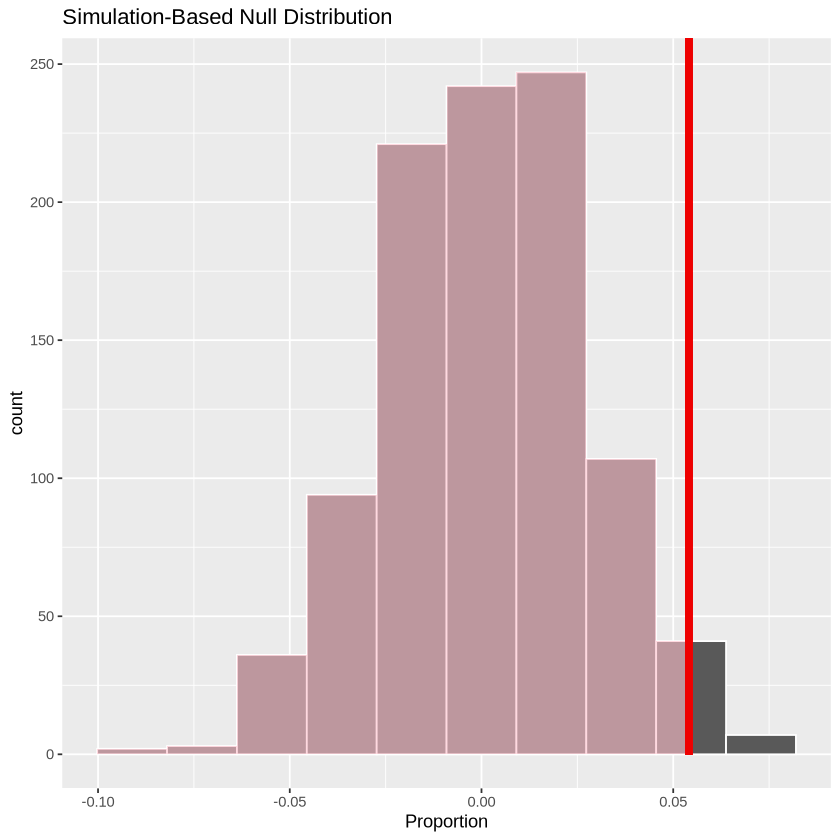

In [17]:
thefts_result_plot <- thefts_null_distribution |>
    visualize(bins = 10) +
    shade_p_value(obs_stat = phat_theft, direction = "left") +
    xlab("Proportion")

thefts_result_plot

In [18]:
thefts_p_value <- thefts_null_distribution |>
    get_p_value(obs_stat = phat_theft, direction = "left")
# Prints the p-value for the difference of proportions (2018-2022 - 2008-2004) in thefts

thefts_p_value

p_value
<dbl>
0.982


##### Break and Enters Hypothesis Testing

In [19]:
# Prints a table that displays how many crimes in the sample were thefts

year <- data.frame(year_range = rep("2004-2008", times = 500))
theft <-ifelse(sample_2004_2008$TYPE == "Break and Enter Commercial" |
               sample_2004_2008$TYPE == "Break and Enter Residential/Other", "yes", "no")  
table_2004_2008_bne <- cbind(year, theft)

year <- data.frame(year_range = rep("2018-2022", times = 500))
theft <-ifelse(sample_2018_2022$TYPE == "Break and Enter Commercial" |
               sample_2018_2022$TYPE == "Break and Enter Residential/Other", "yes", "no")
table_2018_2022_bne <- cbind(year, theft)

bne_table <- rbind(table_2004_2008_bne, table_2018_2022_bne) 

table_11 <- "Table 11 - Break and Enters in Both Samples (yes = theft)"

# Print the transformed table
table_11
head(bne_table)

[1] "Table 11 - Break and Enters in Both Samples (yes = theft)"

,year_range,theft
,<chr>,<chr>
1,2004-2008,yes
2,2004-2008,no
3,2004-2008,no
4,2004-2008,no
5,2004-2008,no
6,2004-2008,no


In [20]:
bne_null_distribution <- bne_table |>
    specify(formula = theft ~ year_range, success = "yes") |>
    hypothesize(null = "independence") |>
    generate(reps = 1000, type = "permute") |>
    calculate(stat = "diff in props", order = c("2018-2022","2004-2008"))

head(bne_null_distribution)

replicate,stat
<int>,<dbl>
1,-0.024
2,0.008
3,-0.004
4,-0.016
5,-0.032
6,-0.016


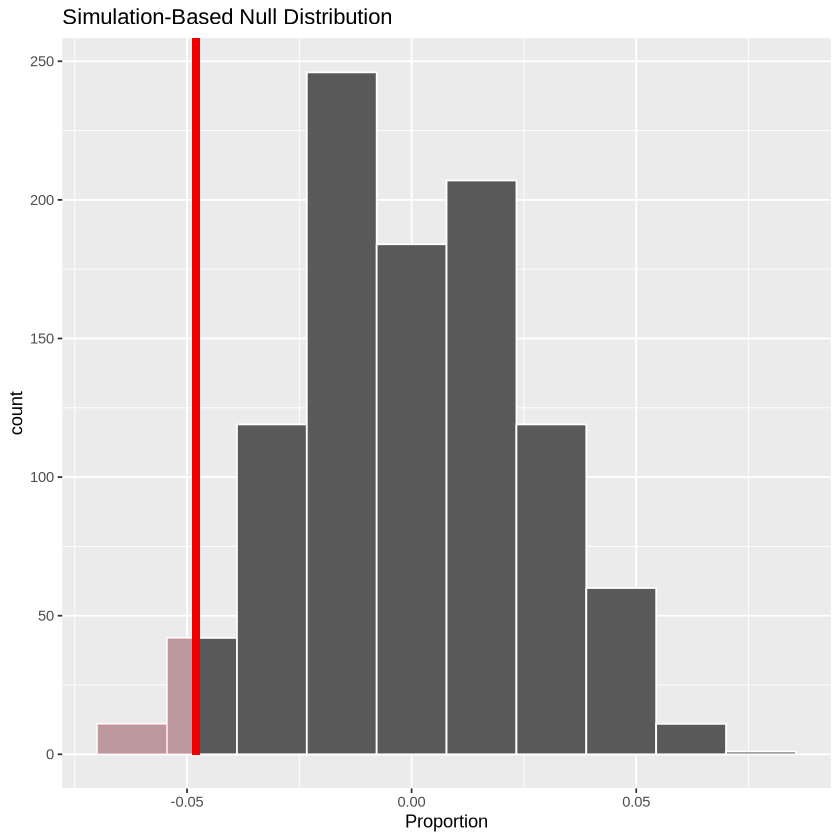

In [21]:
bne_result_plot <- bne_null_distribution |>
    visualize(bins = 10) +
    shade_p_value(obs_stat = phat_bne, direction = "left") +
    xlab("Proportion")

bne_result_plot

In [22]:
bne_p_value <- thefts_null_distribution |>
    get_p_value(obs_stat = phat_bne, direction = "left")

# Prints the p-value for the difference of proportions (2018-2022 - 2008-2004) in break and enters
bne_p_value

p_value
<dbl>
0.031


## Methods: Plan

The report utilizes data provided by the Vancouver Police Department, offering a reliable representation of crime statistics in Vancouver. Our objective is to study the proportion of thefts and break-ins relative to the total crimes, comparing time intervals of 2004-2008 and 2018-2022. Random sampling with sufficiently large sample sizes is used to ensure unbiased and representative point estimates, in order to be able to draw a conclusion towards the population.

However, summarizing our findings with plots and point estimates lack robust support for a hypothesis or a claim. To validate our hypothesis, we use hypothesis testing and a 95% confidence interval. We will use both bootstrapping and asymptotics models and compare them. This is possible because our sample size is large enough and np and nq are larger than 5. Calculating the confidence interval and conducting a hypothesis rest reduces sample variation to ensure an accurate representation of the population. 

We will conduct a difference in proportion hypothesis test confidence interval to determine whether the proportion of break-ins from 2018-2022 differs from those in 2004-2008. Our null hypothesis states that the proportion would remain the same, and our alternate hypothesis examines a decrease in crime proportions, as suggested by Anderson et al. (2017).
We will calculate a confidence interval to determine whether the proportion of theft from 2018-2022 differs from those in 2004-2008.  The confidence interval assesses the difference in proportion of break-in proportions between the stated time periods, to evaluate claims by Anderson et al. (2017) against predictions by Phillip et al. (2012). 

Our report aids the Vancouver Police Department to optimally allocate resources by adjusting resources according to the crimes if proportions have increased or redirecting these to address more prevalent crimes. This analysis may raise future questions about the relationship between unemployment and theft, or identify vulnerable neighborhoods to theft. 


## References

Anderson, M. A., Curman, A. S., & Lining, S. J. (2017). The Trajectories of Crime at Places: 
    Understanding the Patterns of Disaggregated Crime Types. Journal of Quantitative 
    Criminology, 33, 427-449. https://doi.org/10.1007/s10940-016-9301-1 

Phillips, J., & Land, K. C. (2012). The link between unemployment and crime rate fluctuations: 
    An analysis at the county, state, and national levels. Social Science Research, 41(3), 
    681-694. https://doi.org/10.1016/j.ssresearch.2012.01.001 

StatCan. (2023). Rate of unemployment in British Columbia, Canada from 2000 to 2022 
    [Graph]. In Statista. https://www.statista.com/statistics/569373/unemployment-rate-british-columbia-canada/ 